In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import activations, regularizers, initializers

In [ ]:
!git clone https://github.com/devaldicaliesta/waste_dataset.git

fatal: destination path 'waste_dataset' already exists and is not an empty directory.


In [ ]:
import os

DIR = "/content/waste_dataset/wastedataset"

# Fungsi untuk menghitung jumlah file dalam suatu direktori
def count_files(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

# Fungsi untuk mengecek jumlah file dalam setiap folder
def count_files_in_folders(directory):
    folder_count = {}
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            folder_path = os.path.join(root, dir_name)
            file_count = count_files(folder_path)
            folder_count[folder_path] = file_count
    return folder_count

# Memanggil fungsi count_files_in_folders untuk mendapatkan jumlah file dalam setiap folder
folder_counts = count_files_in_folders(DIR)

# Memanggil fungsi count_files untuk menghitung jumlah file
file_count = count_files(DIR)

# Menampilkan hasil
print("Jumlah file dalam direktori", DIR, "adalah:", file_count)
print('\n')

# Menampilkan hasil
for folder, count in folder_counts.items():
    print("Jumlah file dalam folder", folder, "adalah:", count)

Jumlah file dalam direktori /content/waste_dataset/wastedataset adalah: 5079


Jumlah file dalam folder /content/waste_dataset/wastedataset/Glass adalah: 857
Jumlah file dalam folder /content/waste_dataset/wastedataset/Paper and Cardboard adalah: 1398
Jumlah file dalam folder /content/waste_dataset/wastedataset/Organic Waste adalah: 210
Jumlah file dalam folder /content/waste_dataset/wastedataset/Textiles adalah: 335
Jumlah file dalam folder /content/waste_dataset/wastedataset/Other Plastics adalah: 339
Jumlah file dalam folder /content/waste_dataset/wastedataset/Aluminium adalah: 763
Jumlah file dalam folder /content/waste_dataset/wastedataset/Carton adalah: 336
Jumlah file dalam folder /content/waste_dataset/wastedataset/Plastic adalah: 493
Jumlah file dalam folder /content/waste_dataset/wastedataset/Wood adalah: 347


In [ ]:
DIR = "/content/waste_dataset/wastedataset"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                    subset="training", seed=42,
                                                                    batch_size=128, smart_resize=True,
                                                                    image_size=(256, 256))

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation",
                                                                   seed=42, batch_size=128, smart_resize=True,
                                                                   image_size=(256, 256))

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.


In [ ]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"There are {numClasses} classes.")
print(f"The class names are: {classes}")

There are 9 classes.
The class names are: ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

#inceptionv3

In [ ]:
Inception_V3_Model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),weights='imagenet',
                                                       include_top=False,classes=numClasses)

for layer in Inception_V3_Model.layers[:255]:
    layer.trainable = False
for layer in Inception_V3_Model.layers[255:]:
    layer.trainable = True


preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

inputs = tf.keras.Input(shape=(256, 256, 3))
x = preprocess_input(inputs)
x = Inception_V3_Model(x)
x = data_augmentation(x)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

inception_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
inception_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_1 (Sequential)   (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

inception_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

callbacks = tf.keras.callbacks.EarlyStopping(patience=2,
                                             monitor= 'loss',
                                             mode= 'min')
epochs=50
history = inception_model.fit(train_dataset,epochs=epochs, callbacks=[callbacks])

Epoch 1/50
36/36 [==============================] - 35s 452ms/step - loss: 2.1532 - accuracy: 0.3408
Epoch 2/50
36/36 [==============================] - 19s 446ms/step - loss: 1.9504 - accuracy: 0.4695
Epoch 3/50
36/36 [==============================] - 21s 474ms/step - loss: 1.6772 - accuracy: 0.5242
Epoch 4/50
36/36 [==============================] - 19s 453ms/step - loss: 1.4541 - accuracy: 0.5552
Epoch 5/50
36/36 [==============================] - 19s 437ms/step - loss: 1.2817 - accuracy: 0.5773
Epoch 6/50
36/36 [==============================] - 19s 437ms/step - loss: 1.1346 - accuracy: 0.5883
Epoch 7/50
36/36 [==============================] - 19s 439ms/step - loss: 1.0152 - accuracy: 0.6561
Epoch 8/50
36/36 [==============================] - 19s 430ms/step - loss: 0.9129 - accuracy: 0.7884
Epoch 9/50
36/36 [==============================] - 19s 439ms/step - loss: 0.8214 - accuracy: 0.8598
Epoch 10/50
36/36 [==============================] - 19s 440ms/step - loss: 0.7368 - accura

#Resnet152

In [ ]:
baseModel = tf.keras.applications.ResNet152(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False,
    classes=numClasses
)

for layer in baseModel.layers:
    layer.trainable = False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

resnet_model = Model(inputs=baseModel.input, outputs=x)

234698864/234698864 [==============================] - 6s 0us/step


In [ ]:
resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

resnet_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


callbacks = tf.keras.callbacks.EarlyStopping(patience=2,
                                             monitor= 'loss',
                                             mode= 'min')

epochs=50
history = resnet_model.fit(train_dataset,epochs=epochs, callbacks=[callbacks])

Epoch 1/50
36/36 [==============================] - 56s 1s/step - loss: 1.3533 - accuracy: 0.6675
Epoch 2/50
36/36 [==============================] - 42s 1s/step - loss: 0.2132 - accuracy: 0.9271
Epoch 3/50
36/36 [==============================] - 43s 1s/step - loss: 0.0758 - accuracy: 0.9764
Epoch 4/50
36/36 [==============================] - 42s 1s/step - loss: 0.0315 - accuracy: 0.9926
Epoch 5/50
36/36 [==============================] - 43s 1s/step - loss: 0.0177 - accuracy: 0.9965
Epoch 6/50
36/36 [==============================] - 43s 1s/step - loss: 0.0145 - accuracy: 0.9967
Epoch 7/50
36/36 [==============================] - 43s 1s/step - loss: 0.0108 - accuracy: 0.9980
Epoch 8/50
36/36 [==============================] - 43s 1s/step - loss: 0.0094 - accuracy: 0.9987
Epoch 9/50
36/36 [==============================] - 43s 1s/step - loss: 0.0083 - accuracy: 0.9987
Epoch 10/50
36/36 [==============================] - 43s 1s/step - loss: 0.0059 - accuracy: 0.9996
Epoch 11/50
36/36 [

#mobilenet

In [ ]:
# Load MobileNetV3Large model with pre-trained weights
baseModel = MobileNetV3Large(input_shape=(256, 256, 3), weights='imagenet', include_top=False, classes=numClasses)

# Freeze layers except for the last 6 layers
for layer in baseModel.layers[:-6]:
    layer.trainable = False

# Create the model head
last_output = baseModel.layers[-1].output
x = Dropout(0.45)(last_output)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation=activations.elu, kernel_regularizer=regularizers.l1(0.045),
          activity_regularizer=regularizers.l1(0.045), kernel_initializer=initializers.he_normal())(x)
x = Dropout(0.45)(x)
outputs = Dense(numClasses, activation='softmax')(x)

# Create the final model
mobilenet_model = Model(inputs=baseModel.input, outputs=outputs)

In [ ]:
mobilenet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_7[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])


callbacks = tf.keras.callbacks.EarlyStopping(patience=2,
                                             monitor= 'loss',
                                             mode= 'min')
epochs = 50
history = mobilenet_model.fit(train_dataset, epochs=epochs, callbacks=[callbacks])

Epoch 1/50
36/36 [==============================] - 21s 340ms/step - loss: 243.8747 - accuracy: 0.5716
Epoch 2/50
36/36 [==============================] - 21s 391ms/step - loss: 45.3385 - accuracy: 0.7911
Epoch 3/50
36/36 [==============================] - 16s 347ms/step - loss: 6.4658 - accuracy: 0.5447
Epoch 4/50
36/36 [==============================] - 16s 360ms/step - loss: 4.1705 - accuracy: 0.5371
Epoch 5/50
36/36 [==============================] - 16s 353ms/step - loss: 4.0379 - accuracy: 0.5312
Epoch 6/50
36/36 [==============================] - 16s 357ms/step - loss: 3.9782 - accuracy: 0.5248
Epoch 7/50
36/36 [==============================] - 16s 358ms/step - loss: 3.9057 - accuracy: 0.5371
Epoch 8/50
36/36 [==============================] - 16s 379ms/step - loss: 3.8365 - accuracy: 0.5415
Epoch 9/50
36/36 [==============================] - 16s 347ms/step - loss: 3.7669 - accuracy: 0.5526
Epoch 10/50
36/36 [==============================] - 16s 356ms/step - loss: 3.7094 - acc

In [ ]:
mobilenet_model.evaluate(test_dataset)

4/4 [==============================] - 4s 177ms/step - loss: 2.7325 - accuracy: 0.9270


[2.732510566711426, 0.9270216822624207]

In [ ]:
inception_model.evaluate(test_dataset)

4/4 [==============================] - 10s 2s/step - loss: 0.1477 - accuracy: 0.9546


[0.1476898044347763, 0.9546350836753845]

In [ ]:
resnet_model.evaluate(test_dataset)

4/4 [==============================] - 15s 2s/step - loss: 0.3629 - accuracy: 0.9014


[0.36293452978134155, 0.9013806581497192]

In [ ]:
mobilenet_model.save('./mobilenet_model.h5')

In [ ]:
inception_model.save('./inceptionv3_model.h5')

In [ ]:
resnet_model.save('./resnet152_model.h5')

#confusion

4/4 [==============================] - 1s 42ms/step


<Figure size 1000x1000 with 0 Axes>

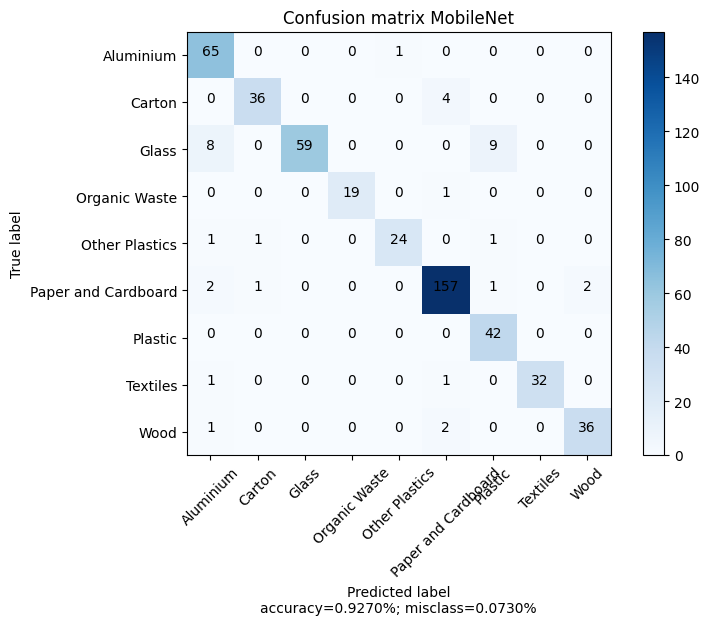

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, target_names, cmap='Blues'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix MobileNet')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:.4f}%; misclass={misclass:.4f}%')
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

# Loop through the test dataset
for images, labels in test_dataset:
    preds = mobilenet_model.predict(images)  # Assuming you have a model named 'model'
    true.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=1))

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), target_names=classes)

4/4 [==============================] - 4s 755ms/step


<Figure size 1000x1000 with 0 Axes>

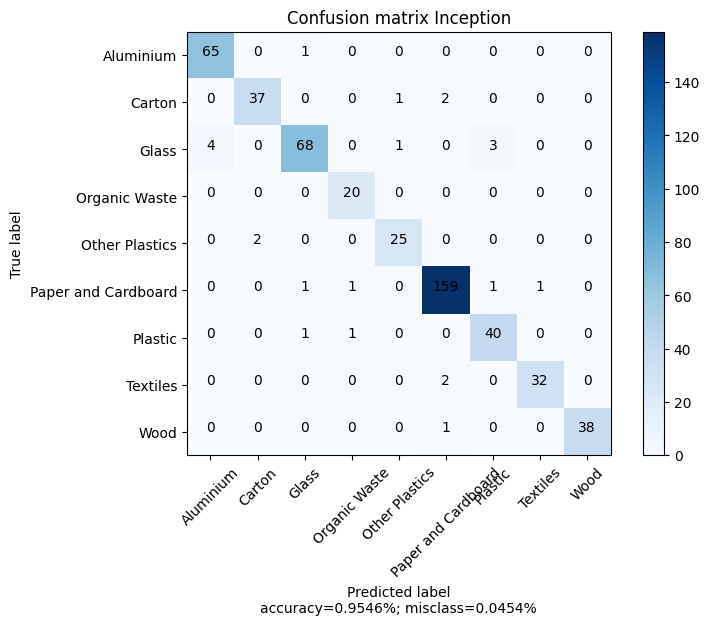

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, target_names, cmap='Blues'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix Inception')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:.4f}%; misclass={misclass:.4f}%')
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

# Loop through the test dataset
for images, labels in test_dataset:
    preds = inception_model.predict(images)  # Assuming you have a model named 'model'
    true.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=1))

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), target_names=classes)

4/4 [==============================] - 5s 749ms/step


<Figure size 1000x1000 with 0 Axes>

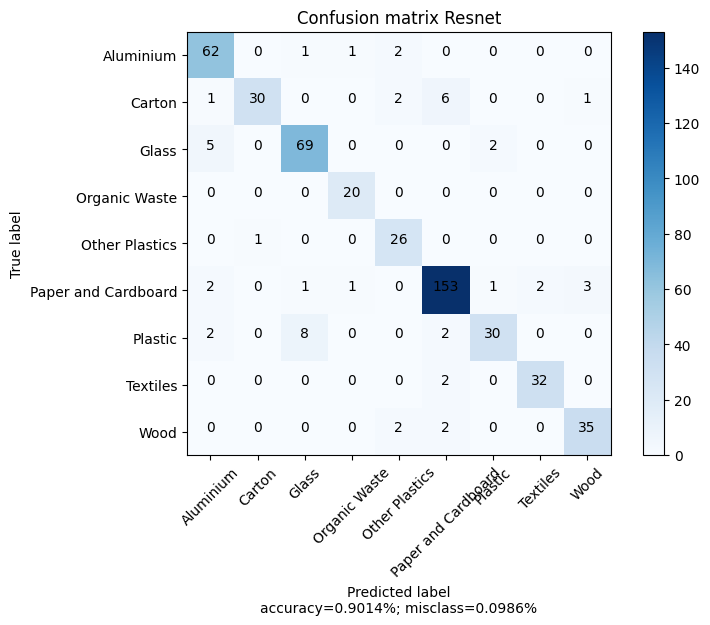

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, target_names, cmap='Blues'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix Resnet')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:.4f}%; misclass={misclass:.4f}%')
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

# Loop through the test dataset
for images, labels in test_dataset:
    preds = resnet_model.predict(images)  # Assuming you have a model named 'model'
    true.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=1))

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), target_names=classes)

In [ ]:
#mobilenet
precision = 0.8762
recall = 0.8872

f1 = 2 * (precision * recall) / (precision + recall)
print("F1-score:", f1)

F1-score: 0.8816656912782126


In [ ]:
#inception
precision = 0.8906
recall = 0.8897

f1 = 2 * (precision * recall) / (precision + recall)
print("F1-score:", f1)

F1-score: 0.8901497725102511


In [ ]:
#inception
precision = 0.8758
recall = 0.8804

f1 = 2 * (precision * recall) / (precision + recall)
print("F1-score:", f1)

F1-score: 0.8780939756291993
